In [1]:
# vesrion 4 - amended word processing
# - fixed miss word from w2v
# - fixed text parsing

In [2]:
from bs4 import BeautifulSoup
import re
import os
from tqdm import tqdm
from collections import Counter
import torch
import time
import gensim
import pymorphy2
import numpy as np

In [3]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dev

device(type='cuda')

In [17]:
proj_types, proj_names, proj_descrs = [],[],[]
folders = os.listdir('texts')
for folder in tqdm(folders):
    f = open(f"texts/{folder}/choose", "r", encoding="utf-8")
    contents = f.read()
    soup = BeautifulSoup(contents, 'lxml')
    founded = soup.find_all('div', {'class': 'lr-project-value'})
    proj_types.append( re.sub(r'[\n\t]', '', founded[1].get_text().lower()) )
    proj_names.append( re.sub(r'[\n\t]', '', founded[3].get_text().lower()) )
    proj_descrs.append( re.sub(r'[\n\t]', '', founded[4].get_text().lower()) )
    f.close()
    


100%|██████████| 6605/6605 [00:37<00:00, 174.43it/s]


In [18]:
from collections import defaultdict

In [19]:
types_dict = defaultdict(int)
for proj_type in (proj_types):
    types_dict[proj_type] += 1
    
for key, value in sorted(types_dict.items(), key=lambda item: item[1], reverse = True):
    print("%s: %s" % (key, value))

другое: 2206
просвещение и образование — новые форматы и темы: 1851
зож: профилактика, а не лечение: 570
семья: сохранение традиций и ценностей: 533
искусственный интеллект и современные технологии на службе обществу: 523
75-я годовщина со дня победы в великой отечественной войне: 308
правовая защита граждан и предпринимателей: 216
проекты в области науки: 159
внутренний туризм: новые формы, новые маршруты: 157
культурно-историческое наследие россии: 82


In [20]:
topic = 'просвещение и образование — новые форматы и темы'

In [21]:
names, descrs = [], []
for i in range( len(proj_names) ):
    if proj_types[i] == topic:
        names.append( proj_names[i] )
        descrs.append( proj_descrs[i] )

In [22]:
len(names)

1851

In [23]:
# process text
for i in range( len(names) ):
    ### NAMES
    # lowcase, no , - : ; ( ) " ' « » and .
    #line = names[i].lower()
    line = names[i]
    line = re.sub(r'[\,\-\:\;\(\)\"\«\»\.\!\?\\\/]', ' ', line)
    line = re.sub(r"\'", ' ', line)
    # change all ... to space
    line = re.sub(r'\.+', ' ', line)
    # no doublespace
    line = re.sub(r' +', ' ', line)
    # no space after .
    #line = re.sub(r'\. ', '.', line)
    names[i] = line.strip()
    
    ### DESCRS
    # lowcase, no , - : ; ( ) " ' « » keep .
    #line = descrs[i].lower()
    line = descrs[i]
    line = re.sub(r'[\,\-\:\;\(\)\"\«\»\\\/]', ' ', line)
    line = re.sub(r"\'", ' ', line)
    # change all ... to .
    line = re.sub(r'\.+', '.', line)
    # ё -> е
    line = re.sub(r'ё', 'е', line)
    # ! > .
    line = re.sub(r'[\!\?]', ".", line)
    # remove all digits and symbols connected to words
    line = re.sub(r'([а-яА-Яa-zA-Z])([\d\:\*]+)', r'\1', line)
    # no doublespace
    line = re.sub(r' +', ' ', line)
    # no space after .
    line = re.sub(r'\. ', '.', line)
    # change all ... to .
    line = re.sub(r'\.+', '.', line)
    descrs[i] = line.strip()

In [24]:
names[0]

'проект нацелен на популяризацию образования в научной сфере заключается в проведении ряда семинаров для школьников открывающих путь к успеху в науке'

In [25]:
descrs[0]

'на сегодняшний день существует социальная проблема связанная с отсутствием информированности школьников о возможностях различных профессий в том числе профессий в области науки.зачастую школьники выбирают дальнейший путь развития с помощью родительского примера информации из сми и других источников о популярности и денежности той или иной сферы.при этом даже будучи студентами вузов не представляют о деятельности по будущей профессии.это значительно влияет на их мотивацию не только во время учебы но и сказывается на эффективности последующей работы.идея проекта заключается в том чтобы перенести школьников на этап работы ученым показать им образ их будущего в данной профессии что позволит выявить вдохновить и направить тех кто будет наиболее эффективным при обучении и работе в этой сфере.на практике будет организован ряд интерактивных семинаров на базе научно исследовательской лаборатории мгту им.н.э.баумана отражающий жизнь и работу в сфере науки погружающий и заинтересовывающий школьн

### Пробуем просто все предложения данной тематике собрать в кучу

In [26]:
all_sents = []
max_slen = 0
for i in range(len(descrs)):
    sents = descrs[i].split('.')
    for j in range(len(sents)):
        sents[j] = sents[j].strip()
        slen = len(sents[j])
        if slen > 0:
            all_sents.append(sents[j])

In [27]:
len(all_sents)

31656

In [28]:
all_sents[1]

'зачастую школьники выбирают дальнейший путь развития с помощью родительского примера информации из сми и других источников о популярности и денежности той или иной сферы'

In [29]:
text = ' '.join(all_sents)
text = re.sub(r'  ', ' ', text)  # убрать двойные пробелы
ALL_WORDS = set(text.strip().split(' '))
len(ALL_WORDS)

43768

In [30]:
c = Counter(text.split(' '))
c.most_common(10)

[('и', 21758),
 ('в', 18693),
 ('на', 7544),
 ('с', 6533),
 ('для', 5374),
 ('по', 4119),
 ('не', 3525),
 ('проекта', 3469),
 ('к', 3143),
 ('как', 2428)]

In [31]:
# # удаляем слова с числом повторений меньше 10
# todelete = set()
# for i, n in c.items():
#     if n < 10:
#         todelete.add(i)
        
# for i in todelete:
#     del c[i]

In [32]:
len(c.keys())

43768

In [33]:
model_w2v = gensim.models.KeyedVectors.load_word2vec_format('embed_models/183 - ruwikiruscorpora-func_upos_skipgram_300_5_2019/model.bin', binary=True)
model_w2v_weights = torch.FloatTensor(model_w2v.vectors).to(dev)

In [34]:
#weights = torch.FloatTensor(model.vectors) # formerly syn0, which is soon deprecated
EMBED_SIZE = model_w2v.vector_size
EMBED_SIZE

300

In [35]:
WORDS_COUNT = len(c.keys())
ALL_WORDS = set([w for w, _ in c.most_common(WORDS_COUNT)])
INDEX_TO_WORD = ['<pad>', '<miss>'] + list(ALL_WORDS)
len(INDEX_TO_WORD)

43770

In [36]:
WORD_TO_INDEX = {w: i for i, w in enumerate(INDEX_TO_WORD)}
INDEX_TO_WORD[:10]

['<pad>',
 '<miss>',
 'звездное',
 'формировали',
 'тренде',
 'периодическое',
 'девушку',
 'думающих',
 'программным',
 'здравомыслов']

In [37]:
# create word_index to embedding array
index_to_embedding = torch.zeros([len(INDEX_TO_WORD), EMBED_SIZE], dtype=torch.float32)
cotags = {'ADJF':'ADJ', # pymorphy2: word2vec 
'ADJS' : 'ADJ', 
'ADVB' : 'ADV', 
'COMP' : 'ADV', 
'GRND' : 'VERB', 
'INFN' : 'VERB', 
'NOUN' : 'NOUN', 
'PRED' : 'ADV', 
'PRTF' : 'ADJ', 
'PRTS' : 'VERB', 
'VERB' : 'VERB',
# my
'CONJ' : 'ADV',
'INTJ' : 'NOUN',
'PREP' : 'PROPN',
'NUMR' : 'NUM',
'PRCL' : 'PROPN',
'NPRO' : 'PRON'
         }

In [38]:
morph = pymorphy2.MorphAnalyzer()
PAD_WORD = 'сингулярность'
MISS_WORD = 'хрень'
#index_to_embedding[0] = torch.from_numpy( model_w2v[PAD_WORD+"_NOUN"] )
index_to_embedding[0] = torch.zeros(EMBED_SIZE)
index_to_embedding[1] = torch.from_numpy( model_w2v[MISS_WORD+"_NOUN"] )

cnotfound_in_pymorphy = 0
cnotfound_in_w2v = 0
not_found_in_pymorphy = []
not_found_in_w2v = []

for i in tqdm( range(2,len(INDEX_TO_WORD)) ):
    word = INDEX_TO_WORD[i]
    #print (word)
    info = morph.parse(word)[0]
    if ('UNKN' in info.tag) or ('LATN' in info.tag) or ('NUMB' in info.tag) or ('PNCT' in info.tag) or ('ROMN' in info.tag):
        info = morph.parse(MISS_WORD)[0]
        cnotfound_in_pymorphy += 1
        not_found_in_pymorphy.append(word)
        
    p_speech = cotags[info.tag.POS]
    w2v_form = info.normal_form + "_" + p_speech
    
    #debug
    if w2v_form.startswith('касаться'):
        print (morph.parse(word))
    
    if w2v_form in model_w2v:
        index_to_embedding[i] = torch.from_numpy( model_w2v[w2v_form] )
    else:
        if p_speech == 'ADV':
            p_speech = 'ADJ'
            w2v_form = info.normal_form + "_" + p_speech
            if w2v_form in model_w2v:
                index_to_embedding[i] = torch.from_numpy( model_w2v[w2v_form] )
            else:
                cnotfound_in_w2v += 1
                not_found_in_w2v.append(w2v_form)
                index_to_embedding[i] = index_to_embedding[1]  # MISS_WORD
        else:
            if p_speech == 'ADJ':
                p_speech = 'ADV'
                w2v_form = info.normal_form + "_" + p_speech
                if w2v_form in model_w2v:
                    index_to_embedding[i] = torch.from_numpy( model_w2v[w2v_form] )
                else:
                    cnotfound_in_w2v += 1
                    not_found_in_w2v.append(w2v_form)
                    index_to_embedding[i] = index_to_embedding[1]  # MISS_WORD

print (f'Not found pmorphy2: {cnotfound_in_pymorphy}, not found in w2v: {cnotfound_in_w2v}')

  3%|▎         | 1097/43768 [00:00<00:08, 5258.93it/s]

[Parse(word='касаются', tag=OpencorporaTag('VERB,impf,intr plur,3per,pres,indc'), normal_form='касаться', score=1.0, methods_stack=((<DictionaryAnalyzer>, 'касаются', 224, 6),))]


 16%|█▋        | 7183/43768 [00:01<00:06, 5917.17it/s]

[Parse(word='касающуюся', tag=OpencorporaTag('PRTF,impf,intr,pres,actv femn,sing,accs'), normal_form='касаться', score=1.0, methods_stack=((<DictionaryAnalyzer>, 'касающуюся', 224, 23),))]
[Parse(word='касающихся', tag=OpencorporaTag('PRTF,impf,intr,pres,actv plur,gent'), normal_form='касаться', score=0.5, methods_stack=((<DictionaryAnalyzer>, 'касающихся', 224, 34),)), Parse(word='касающихся', tag=OpencorporaTag('PRTF,impf,intr,pres,actv plur,loct'), normal_form='касаться', score=0.333333, methods_stack=((<DictionaryAnalyzer>, 'касающихся', 224, 39),)), Parse(word='касающихся', tag=OpencorporaTag('PRTF,impf,intr,pres,actv anim,plur,accs'), normal_form='касаться', score=0.166666, methods_stack=((<DictionaryAnalyzer>, 'касающихся', 224, 36),))]


 37%|███▋      | 16333/43768 [00:02<00:04, 6114.46it/s]

[Parse(word='касающегося', tag=OpencorporaTag('PRTF,impf,intr,pres,actv masc,sing,gent'), normal_form='касаться', score=0.3333333333333333, methods_stack=((<DictionaryAnalyzer>, 'касающегося', 224, 14),)), Parse(word='касающегося', tag=OpencorporaTag('PRTF,impf,intr,pres,actv anim,masc,sing,accs'), normal_form='касаться', score=0.3333333333333333, methods_stack=((<DictionaryAnalyzer>, 'касающегося', 224, 16),)), Parse(word='касающегося', tag=OpencorporaTag('PRTF,impf,intr,pres,actv neut,sing,gent'), normal_form='касаться', score=0.3333333333333333, methods_stack=((<DictionaryAnalyzer>, 'касающегося', 224, 28),))]
[Parse(word='касающиеся', tag=OpencorporaTag('PRTF,impf,intr,pres,actv plur,nomn'), normal_form='касаться', score=0.5, methods_stack=((<DictionaryAnalyzer>, 'касающиеся', 224, 33),)), Parse(word='касающиеся', tag=OpencorporaTag('PRTF,impf,intr,pres,actv inan,plur,accs'), normal_form='касаться', score=0.5, methods_stack=((<DictionaryAnalyzer>, 'касающиеся', 224, 37),))]


 44%|████▍     | 19410/43768 [00:03<00:04, 6082.06it/s]

[Parse(word='касающейся', tag=OpencorporaTag('PRTF,impf,intr,pres,actv femn,sing,gent'), normal_form='касаться', score=0.25, methods_stack=((<DictionaryAnalyzer>, 'касающейся', 224, 21),)), Parse(word='касающейся', tag=OpencorporaTag('PRTF,impf,intr,pres,actv femn,sing,datv'), normal_form='касаться', score=0.25, methods_stack=((<DictionaryAnalyzer>, 'касающейся', 224, 22),)), Parse(word='касающейся', tag=OpencorporaTag('PRTF,impf,intr,pres,actv femn,sing,ablt'), normal_form='касаться', score=0.25, methods_stack=((<DictionaryAnalyzer>, 'касающейся', 224, 24),)), Parse(word='касающейся', tag=OpencorporaTag('PRTF,impf,intr,pres,actv femn,sing,loct'), normal_form='касаться', score=0.25, methods_stack=((<DictionaryAnalyzer>, 'касающейся', 224, 26),))]


 61%|██████    | 26737/43768 [00:04<00:02, 6037.13it/s]

[Parse(word='касается', tag=OpencorporaTag('VERB,impf,intr sing,3per,pres,indc'), normal_form='касаться', score=1.0, methods_stack=((<DictionaryAnalyzer>, 'касается', 224, 5),))]


100%|██████████| 43768/43768 [00:07<00:00, 6033.57it/s]

Not found pmorphy2: 1834, not found in w2v: 2190


In [39]:
[x for x in model_w2v.vocab.keys() if x.startswith('касать')]

['касаться_VERB', 'касаться_NOUN']

In [40]:
len (model_w2v.vocab.keys())

248118

In [41]:
not_found_in_pymorphy

['10000',
 'excel',
 'pomoch',
 'олимпиады…',
 'youdo',
 'ый',
 '5000',
 'дв',
 '970',
 'rg',
 'idkiryanov_yuriy@mail',
 'ипо',
 'poedinki',
 '39%',
 'giving',
 'am',
 'pmbok',
 'соц',
 'unit',
 'polytechnicum',
 '43%',
 'business',
 '40%',
 'призвание”',
 'science',
 'геймификации•',
 'built',
 '375',
 '%',
 'мсб',
 'viber',
 'kontakte',
 '20202',
 'komi',
 'ted',
 '34%',
 'гк',
 'secure',
 'гп',
 'tatarstan',
 'peacemanru',
 '15%',
 '~21',
 'exel',
 'learning',
 'iq',
 'win',
 '32625',
 'cad',
 '30+',
 'мэс',
 'report',
 'лр',
 'лна',
 'certificate',
 'mos',
 '№3',
 'iii',
 'лицее…',
 'народов…',
 'scopus',
 'рсо',
 '43',
 '1996\u200b',
 'картинкой̆',
 '3х',
 'r&d',
 'programmy',
 'obuchayushchie',
 'slam',
 '93',
 '1б',
 'consulting',
 'runet',
 '85%',
 '1991',
 'project',
 'voice',
 'think',
 'smi',
 'cant',
 'итп',
 'ве',
 'rot',
 'радость”',
 '1992',
 '12014268_107559964',
 '15000',
 'facebook',
 'customer',
 '2017–2023',
 'steam',
 '130',
 'consult',
 'e',
 'nirhtu',
 '№16',
 'w

In [42]:
info= morph.parse('помогающий')[0]
w2v_form = info.normal_form + "_" + cotags[info.tag.POS]
if w2v_form in model_w2v.vocab:
    print ('ok')
    
print (w2v_form)


помогать_ADJ


In [43]:
w2v_form = 'миллион_ADJ'
if w2v_form in model_w2v:
    print ('ok')

In [44]:
model_w2v['помогать_ADV']

array([-0.01618683,  0.08149137, -0.41003856,  0.09214458, -0.11977311,
       -0.3724174 , -0.34318662, -0.12474118,  0.35099894,  0.1571057 ,
       -0.15855333,  0.4204024 ,  0.29632124,  0.2672897 ,  0.08501317,
       -0.18794422,  0.3186416 , -0.24534512, -0.18272066, -0.51683277,
        0.37425128, -0.12486651,  0.19826324,  0.19135913,  0.05424773,
        0.0990174 ,  0.09452809, -0.22307342, -0.43266228,  0.07762914,
        0.29195598,  0.0322699 , -0.2712187 , -0.06350715,  0.02729418,
        0.27723494, -0.3157307 , -0.00605955,  0.12486151, -0.22318703,
        0.21392816,  0.14042565,  0.07341375,  0.11503113, -0.14059882,
        0.19299929,  0.01590859, -0.00649329, -0.47186562,  0.22422631,
        0.35057417,  0.15454423, -0.05597629,  0.1640026 ,  0.0571834 ,
       -0.14884542,  0.00235512, -0.35851142,  0.07240575, -0.04732075,
       -0.0594007 ,  0.21944952,  0.3371421 , -0.02267027,  0.23568194,
       -0.41087788, -0.24301678,  0.07140356, -0.22640683,  0.10

In [45]:
w2v_form = 'помогающий_ADJ'
if w2v_form in model_w2v:
    print ('ok')

In [46]:
not_found_in_w2v

['добиться_ADV',
 'тугурый_ADV',
 'фмежрегиональный_ADV',
 'компетентностный_ADV',
 'ивсесторонний_ADV',
 'приспособить_ADV',
 'поставить_ADV',
 'оборудованый_ADV',
 'развивающийся_ADV',
 'нурминский_ADV',
 'значимостиединственный_ADV',
 'пфдый_ADV',
 'расслоить_ADV',
 'предназначить_ADV',
 'популяризировать_ADV',
 'непринуждённый_ADV',
 'социально–психолого–педагогический_ADV',
 'серебрянный_ADV',
 'высокопроизводственный_ADV',
 'севераключевой_ADV',
 'ориентироваться_ADV',
 'участвовать_ADV',
 '“мый_ADV',
 'опробовать_ADV',
 'проектадать_ADV',
 'весёлый_ADV',
 'отдалённый_ADV',
 'профилакический_ADV',
 '11что_ADJ',
 'матёрый_ADV',
 'грамонтный_ADV',
 'коучий_ADV',
 'популяризировать_ADV',
 'кое=где_ADJ',
 'бурбашский_ADV',
 'практиковаться_ADV',
 'оплатить_ADV',
 'врождённый_ADV',
 'словоуважаемый_ADV',
 'подразумевать_ADV',
 'стартаперский_ADV',
 'оговорить_ADV',
 'практичёкий_ADV',
 'самозанятой_ADV',
 'проекта•основный_ADV',
 'председательнаблюдательный_ADV',
 'соломатовый_ADV',
 

In [47]:
c['взаимопонимания……']

1

In [48]:
morph.parse('красивый')

[Parse(word='красивый', tag=OpencorporaTag('ADJF,Qual masc,sing,nomn'), normal_form='красивый', score=0.5, methods_stack=((<DictionaryAnalyzer>, 'красивый', 1800, 0),)),
 Parse(word='красивый', tag=OpencorporaTag('ADJF,Qual inan,masc,sing,accs'), normal_form='красивый', score=0.5, methods_stack=((<DictionaryAnalyzer>, 'красивый', 1800, 4),))]

In [49]:
beau = morph.parse('красивая')[0]
beau

Parse(word='красивая', tag=OpencorporaTag('ADJF,Qual femn,sing,nomn'), normal_form='красивый', score=1.0, methods_stack=((<DictionaryAnalyzer>, 'красивая', 1800, 7),))

In [27]:
beau.inflect({'femn'})

Parse(word='красивая', tag=OpencorporaTag('ADJF,Qual femn,sing,nomn'), normal_form='красивый', score=1.0, methods_stack=((<DictionaryAnalyzer>, 'красивая', 1800, 7),))

In [50]:
%matplotlib inline
import matplotlib.pyplot as plt

(array([8.039e+03, 7.068e+03, 6.298e+03, 4.411e+03, 2.430e+03, 1.376e+03,
        7.910e+02, 4.350e+02, 2.550e+02, 1.670e+02, 1.070e+02, 6.300e+01,
        4.900e+01, 3.500e+01, 2.700e+01, 2.100e+01, 1.500e+01, 6.000e+00,
        5.000e+00, 1.300e+01, 8.000e+00, 5.000e+00, 6.000e+00, 2.000e+00,
        4.000e+00, 4.000e+00, 5.000e+00, 1.000e+00, 2.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([  1.  ,   6.98,  12.96,  18.94,  24.92,  30.9 ,  36.88,  42.86,
         48.84,  54.82,  60.8 ,  66.78,  72.76,  78.74,  84.72,  90.7 ,
         96.68, 102.66, 108.64, 114.62, 120.6 , 126.58, 132.56, 138.54,
        144.52, 150.5 , 156.48, 162.46, 168.44, 174.42, 180.4 , 186.38,
        192.36, 198.34, 204.32, 210.3 , 216.28, 222.26, 228.24, 234.22,
        240.2 , 

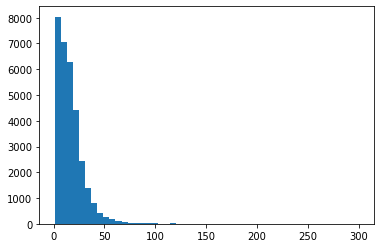

In [51]:
# распреление длины слов в предложении
plt.hist([len(s.split(' ')) for s in all_sents], bins=50)

In [53]:
MAX_LEN = 40

In [54]:
X = torch.zeros((len(all_sents), MAX_LEN), dtype=int)
# готовим матрицу - строка - предложение, столбец - индекс слова в этой позиции
for i in tqdm(range(len(all_sents))):
    for j, w in enumerate(all_sents[i].split(' ')):
        if j >= MAX_LEN:
            break
        X[i, j] = WORD_TO_INDEX.get(w, WORD_TO_INDEX['<miss>'])
        
X = X.to(dev)

100%|██████████| 31656/31656 [00:03<00:00, 10345.68it/s]


In [55]:
X[0:1]

tensor([[30279, 18467, 29005, 25634, 14227, 15129, 22024, 35266, 26511, 20818,
         41359, 25753, 18088, 40899, 36615,  6062,  9888, 10728, 36615,  6062,
         13028, 18981,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]],
       device='cuda:0')

In [56]:
X.shape

torch.Size([31656, 40])

In [57]:
a = [1,2,3]
[i*2 for i in a]

[2, 4, 6]

In [58]:
BATCH_SIZE = 50

In [77]:
class Network(torch.nn.Module):

    def __init__(self, dev, model_w2v_weights):
        super(Network, self).__init__()
        self.dev = dev
        self.word_embeddings = torch.nn.Embedding.from_pretrained(model_w2v_weights).to(self.dev)
        self.gru = torch.nn.GRU(EMBED_SIZE, 300, num_layers = 1, batch_first=True).to(self.dev)
        self.hidden2tag = torch.nn.Linear(300, len(INDEX_TO_WORD)).to(self.dev)
        
    def get_embeddings(self,sentences):
        csentences = sentences.size()[0]
        cwords = sentences.size()[1]
        embeds = torch.zeros(csentences, cwords, EMBED_SIZE).to(self.dev)
        for i in range(csentences):  
            for k in range(cwords):
                if sentences[i][k] == 0:
                    embeds[i][k] = self.word_embeddings[0]
                    break
                embeds[i][k] = torch.FloatTensor ([ emb for emb in self.word_embeddings[ sentences[i][k] ] ])
        return embeds

    def forward(self, sentences):
        embeds = self.word_embeddings(sentences)
        gru_out, state = self.gru(embeds)
        tag_space = self.hidden2tag(gru_out.reshape(-1, 300))
        return tag_space.reshape(sentences.shape[0], sentences.shape[1], -1), state
    
    def forward_state(self, sentences, state):
        #embeds = self.get_embeddings(sentences)
        embeds = self.word_embeddings(sentences)
        gru_out, state = self.gru(embeds, state)
        tag_space = self.hidden2tag(gru_out.reshape(-1, 300))
        return tag_space.reshape(sentences.shape[0], sentences.shape[1], -1), state

In [78]:
model = Network(dev, model_w2v_weights)
model.forward(X[0:1])[0].shape

torch.Size([1, 40, 43770])

In [79]:
def generate_sentence(line):
    sentence = line.split(' ')
    #sentence = ['к', 'а', 'к', ' ', 'р', 'а', 'н', 'о',' ']
    state = None
    for i in range(MAX_LEN):
        #X = torch.Tensor([[WORD_TO_INDEX[sentence[i]]]]).type(torch.long)
        X = torch.Tensor([[WORD_TO_INDEX.get(sentence[i],WORD_TO_INDEX['<miss>'])]]).type(torch.long)
        #get(w, WORD_TO_INDEX['<miss>']
        X = X.to(dev)
        if i == 0:
            result, state = model.forward(X)
        else:
            result, state = model.forward_state(X, state)
        prediction = result[0, -1, :]
        index_of_prediction = prediction.argmax()
        if i >= len(sentence) - 1:
            if index_of_prediction == 0:
                break
        sentence.append(INDEX_TO_WORD[index_of_prediction])
        
    line = ' '.join(sentence)
    line = re.sub(r'none.*$', '', line)
    print(line)

In [80]:
generate_sentence('проект направлена на')

проект направлена на энергосети краевые минобразованием предлагаемым поощрять месту растений разрабатываемая заставить приглашаем глобальный беременных определяемого давать давать царской царской десятков синапсы прошлый курируемых царской европейском широкофюзеляжные аркадием умвд преподавательским царской царской стоимость британский британский ртутные омвд пожалел раздоры обеспечению речевого зал курской


In [100]:
lrate = 0.1

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lrate)
#optimizer = torch.optim.Adam(model.parameters(), lr=lrate)

In [101]:
count = 0

for ep in range(4000):
    
    start = time.time()
    train_loss = 0.
    train_passed = 0
    
    for i in range(int(len(X) / 100)):
        batch = X[i * BATCH_SIZE:(i + 1) * BATCH_SIZE]
        X_batch = batch[:, :-1]
        Y_batch = batch[:, 1:].flatten()

        optimizer.zero_grad()
        answers, _ = model.forward(X_batch)
        answers = answers.view(-1, len(INDEX_TO_WORD))
        loss = criterion(answers, Y_batch)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        train_passed += 1
    end = time.time()
    
    count += 1
    if count == 1:
        count = 0
        trloss = train_loss / train_passed
        print("Epoch {}. Time: {:.3f}, Train loss: {:.3f}".format(ep, end - start, trloss))
        #generate_sentence('проект позволяет')

Epoch 0. Time: 11.041, Train loss: 0.870
Epoch 1. Time: 11.066, Train loss: 0.869
Epoch 2. Time: 11.171, Train loss: 0.868
Epoch 3. Time: 11.058, Train loss: 0.868
Epoch 4. Time: 11.051, Train loss: 0.868
Epoch 5. Time: 11.053, Train loss: 0.868
Epoch 6. Time: 11.049, Train loss: 0.868
Epoch 7. Time: 11.048, Train loss: 0.868
Epoch 8. Time: 11.047, Train loss: 0.868
Epoch 9. Time: 11.050, Train loss: 0.868
Epoch 10. Time: 11.051, Train loss: 0.868
Epoch 11. Time: 11.055, Train loss: 0.868
Epoch 12. Time: 11.062, Train loss: 0.868
Epoch 13. Time: 11.054, Train loss: 0.868
Epoch 14. Time: 11.057, Train loss: 0.868
Epoch 15. Time: 11.048, Train loss: 0.867
Epoch 16. Time: 11.068, Train loss: 0.867
Epoch 17. Time: 11.057, Train loss: 0.867
Epoch 18. Time: 11.057, Train loss: 0.867
Epoch 19. Time: 11.056, Train loss: 0.867
Epoch 20. Time: 11.048, Train loss: 0.867
Epoch 21. Time: 11.107, Train loss: 0.867
Epoch 22. Time: 11.060, Train loss: 0.867
Epoch 23. Time: 11.061, Train loss: 0.867
Ep

KeyboardInterrupt: 

In [91]:
generate_sentence('предлагается')

предлагается создать площадку клуб и готовыми литературы в каждом городе на которой высококвалифицированных технических кадров инженеров игр рф


In [92]:
generate_sentence('проект позволяет')

проект позволяет направлен объяснить на для территории детей российской в федерации вопросах <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


In [93]:
generate_sentence('в нашей стране дети')

в нашей стране дети рамках стране в в проекта тяжело рамках рамках – для занятия занятия сервисы повышения занятия занятия в образования занятия занятия том и занятия в в занятия занятия том сторону занятия занятия занятия в в в в том семье семье семье


In [94]:
generate_sentence('низкий уровень образования')

низкий уровень образования уровень закрепления для внутренних кто создания инвестиций жизнью внутренних <pad> <pad> инвестиций <pad> <pad> им <pad> <pad> выхода <pad> <pad> недостаточное <pad> <pad> потребления <pad> <pad> или <pad> <pad> пенсионеров <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


In [95]:
generate_sentence('проект способен')

проект способен направлен минимальных на порядка базе уровне районных библиотек для в детей области и поведения московской <pad> области <pad> поведения <pad> в <pad> том <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


In [59]:
descrs[105]


'предлагается создание платформы и онлайн курсов ориентированных на людей среднего возраста для повышения языковой финансовой и юридической грамотности.формат курсов будет открытый то есть доступный для всех без каких либо ограничений в том числе и территориальных.технология курсов будет соответствовать требованиям технологии массовых открытых онлайн курсов моок .лекции будут прочитаны ведущими специалистами и преподавателями в соответствующих областях.после каждой лекции будут тесты для самопроверки по пройденному материалу.в конце обучения будет предложено творческое задание для взаимного оценивания.обучающиеся успешно прошедшие обучение будут допущены до аттестации по итогам которой будут выжданы электронные сертификаты подтверждающие результаты обучения.'

In [102]:
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, "model_allw_w2v_rnn1l-300-300-bs50loss0d9.pt")

In [47]:
# model = TheModelClass(*args, **kwargs)
# optimizer = TheOptimizerClass(*args, **kwargs)

checkpoint = torch.load("model_allw_w2v_rnn1l-300-128-loss0d86.pt")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
loss = checkpoint['loss']

#model.eval()
model.train()

Network(
  (word_embeddings): Embedding(248118, 300)
  (gru): GRU(300, 128, batch_first=True)
  (hidden2tag): Linear(in_features=128, out_features=44946, bias=True)
)

In [45]:
model.train()

Network(
  (word_embeddings): Embedding(248118, 300)
  (gru): GRU(300, 128, batch_first=True)
  (hidden2tag): Linear(in_features=128, out_features=44946, bias=True)
)

In [141]:
# NO TRAIN TEST ONLY
BATCH_SIZE = 50
count = 0

for ep in range(1):
    
    start = time.time()
    train_loss = 0.
    train_passed = 0
    
    for i in range(int(len(X) / BATCH_SIZE)):
        batch = X[i * BATCH_SIZE:(i + 1) * BATCH_SIZE]
        X_batch = batch[:, :-1]
        Y_batch = batch[:, 1:].flatten()

        #optimizer.zero_grad()
        answers, _ = model.forward(X_batch)
        answers = answers.view(-1, len(INDEX_TO_WORD))
        loss = criterion(answers, Y_batch)
        train_loss += loss.item()

        #loss.backward()
        #optimizer.step()
        train_passed += 1
    end = time.time()
    
    count += 1
    if count == 1:
        count = 0
        trloss = train_loss / train_passed
        print("Epoch {}. Time: {:.3f}, Train loss: {:.3f}".format(ep, end - start, trloss))
        #generate_sentence('проект позволяет')

Epoch 0. Time: 2.087, Train loss: 1.747


In [164]:
c['преподаватели']

84

In [44]:
c['будет']

1283

In [48]:
c.most_common(500)

[('и', 21757),
 ('в', 18684),
 ('на', 7540),
 ('с', 6533),
 ('для', 5371),
 ('по', 4117),
 ('не', 3524),
 ('проекта', 3413),
 ('к', 3142),
 ('как', 2422),
 ('что', 2298),
 ('а', 2041),
 ('детей', 1997),
 ('из', 1893),
 ('о', 1651),
 ('проект', 1626),
 ('это', 1586),
 ('их', 1507),
 ('или', 1477),
 ('от', 1449),
 ('1', 1315),
 ('–', 1285),
 ('будет', 1283),
 ('у', 1203),
 ('образования', 1184),
 ('при', 1184),
 ('2', 1170),
 ('которые', 1116),
 ('за', 1075),
 ('также', 1052),
 ('3', 1010),
 ('развития', 987),
 ('но', 983),
 ('работы', 973),
 ('так', 973),
 ('обучения', 933),
 ('реализации', 926),
 ('жизни', 909),
 ('будут', 877),
 ('россии', 787),
 ('профессии', 767),
 ('может', 764),
 ('создание', 763),
 ('области', 763),
 ('людей', 759),
 ('деятельности', 758),
 ('быть', 735),
 ('только', 709),
 ('т', 708),
 ('то', 705),
 ('рамках', 705),
 ('до', 705),
 ('можно', 704),
 ('школьников', 701),
 ('более', 693),
 ('время', 686),
 ('проведение', 679),
 ('все', 676),
 ('4', 669),
 ('они', 66

In [162]:
# save descrs to disk
import pandas as pd
df = pd.DataFrame(descrs)
df.to_csv("descrs.csv", encoding = 'utf8')


### Пробуем эмбеддинги word2vec


ModuleNotFoundError: No module named 'gensim'